In [53]:
import multiprocessing as mp
import matplotlib.pyplot as plt
import time

In [3]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from math import sqrt, exp


def initializeWeights(n_in, n_out):
    """
    # initializeWeights return the random weights for Neural Network given the
    # number of node in the input layer and output layer

    # Input:
    # n_in: number of nodes of the input layer
    # n_out: number of nodes of the output layer
       
    # Output: 
    # W: matrix of random initial weights with size (n_out x (n_in + 1))"""

    epsilon = sqrt(6) / sqrt(n_in + n_out + 1)
    W = (np.random.rand(n_out, n_in + 1) * 2 * epsilon) - epsilon
    return W


def sigmoid(z):
    """# Notice that z can be a scalar, a vector or a matrix
    # return the sigmoid of input z"""

    return 1 / (1 + np.exp(-z))

def preprocess():
    """ Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.

     Output:
     train_data: matrix of training set. Each row of train_data contains 
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data 
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the 
       training set
     test_data: matrix of training set. Each row of test_data contains 
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set

     Some suggestions for preprocessing step:
     - feature selection"""

    mat = loadmat('mnist_all.mat')  # loads the MAT object as a Dictionary

    # Split the training sets into two sets of 50000 randomly sampled training examples and 10000 validation examples.     
    train_size = 50_000
    valid_size = 10_000
    test_size  = 10_000

    feature_size = 784

    train_valid_data = np.empty((0, feature_size))
    train_valid_label = np.empty((0, 1))

    train_data = np.empty((0, feature_size))
    train_label = np.empty((0, 1))

    validation_data = np.empty((0, feature_size))
    validation_label = np.empty((0, 1))

    test_data = np.empty((0, feature_size))
    test_label = np.empty((0, 1))

    for key in mat:
        if key.startswith('train'):
            labels = np.ones(mat[key].shape[0]) * int(key[-1])
            train_valid_data = np.vstack([train_valid_data, mat[key]])
            train_valid_label = np.vstack([train_valid_label, labels.reshape(mat[key].shape[0], 1)])
        elif key.startswith('test'):
            labels = np.ones(mat[key].shape[0]) * int(key[-1])
            test_data = np.vstack([test_data, mat[key]])
            test_label = np.vstack([test_label, labels.reshape(mat[key].shape[0], 1)])
            
    idxs = np.random.permutation(train_size + valid_size)

    train_data = train_valid_data[idxs[:train_size], :]
    train_label = train_valid_label[idxs[:train_size]]

    validation_data = train_valid_data[idxs[train_size:], :]
    validation_label = train_valid_label[idxs[train_size:]]
    

    # Feature selection
    idx_to_del = []
    for i in range(feature_size):
        if train_data[:, i].min() == train_data[:, i].max() and validation_data[:, i].min() == validation_data[:, i].max():
            idx_to_del.append(i)
        
    train_data = np.delete(train_data, idx_to_del, axis=1)
    validation_data = np.delete(validation_data, idx_to_del, axis=1)
    test_data = np.delete(test_data, idx_to_del, axis=1)

    print('preprocess done')

    return train_data, train_label, validation_data, validation_label, test_data, test_label


def nnObjFunction(params, *args):
    """% nnObjFunction computes the value of objective function (negative log 
    %   likelihood error function with regularization) given the parameters 
    %   of Neural Networks, thetraining data, their corresponding training 
    %   labels and lambda - regularization hyper-parameter.

    % Input:
    % params: vector of weights of 2 matrices w1 (weights of connections from
    %     input layer to hidden layer) and w2 (weights of connections from
    %     hidden layer to output layer) where all of the weights are contained
    %     in a single vector.
    % n_input: number of node in input layer (not include the bias node)
    % n_hidden: number of node in hidden layer (not include the bias node)
    % n_class: number of node in output layer (number of classes in
    %     classification problem
    % training_data: matrix of training data. Each row of this matrix
    %     represents the feature vector of a particular image
    % training_label: the vector of truth label of training images. Each entry
    %     in the vector represents the truth label of its corresponding image.
    % lambda: regularization hyper-parameter. This value is used for fixing the
    %     overfitting problem.
       
    % Output: 
    % obj_val: a scalar value representing value of error function
    % obj_grad: a SINGLE vector of gradient value of error function
    % NOTE: how to compute obj_grad
    % Use backpropagation algorithm to compute the gradient of error function
    % for each weights in weight matrices.

    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    % reshape 'params' vector into 2 matrices of weight w1 and w2
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit j in input 
    %     layer to unit i in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit j in hidden 
    %     layer to unit i in output layer."""

    n_input, n_hidden, n_class, training_data, training_label, lambdaval = args

    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    obj_val = 0

    # Your code here
    n_train = training_data.shape[0]
    
    # add bias to training data
    training_data = np.hstack([training_data, np.ones((n_train, 1))])
    
    layer_one_net = np.dot(training_data, w1.T)
    # activation function
    layer_one_out = sigmoid(layer_one_net)
    
    # add bias to layer one
    layer_one_out = np.hstack([layer_one_out, np.ones((n_train, 1))])
    
    output_net = np.dot(layer_one_out, w2.T)
    # activation function
    output = sigmoid(output_net)
    
    # one hot encode labels
    encoded_labels = np.zeros((n_train, n_class))
    for idx in range(n_train):
        encoded_labels[idx][int(training_label[idx][0])] = 1.0
    
    delta = output - encoded_labels
    
    # w2 gradient: derivative of error function with respect to the weight from the hidden unit to output unit
    w2_grad = np.dot(delta.T, layer_one_out)
    
    w1_grad = layer_one_out * (1 - layer_one_out) * np.dot(delta, w2)
    w1_grad = np.dot(w1_grad.T, training_data)
    
    # remove gradient for bias term
    w1_grad = w1_grad[:-1, :]
    
    # negative log loss
    loss = -np.sum((encoded_labels * np.log(output)) + (1.0 - encoded_labels) * np.log(1.0 - output))
    
    mean_loss = loss/n_train
    
    reg = (lambdaval / 2 * n_train) * ((np.sum(w1 * w1) + np.sum(w2 * w2)))
    obj_val = loss + reg
        
    w1_grad = (w1_grad + (lambdaval * w1)) / n_train
    w2_grad = (w2_grad + (lambdaval * w2)) / n_train

    # Make sure you reshape the gradient matrices to a 1D array. for instance if your gradient matrices are grad_w1 and grad_w2
    # you would use code similar to the one below to create a flat array
    # obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()),0)
    
    obj_grad = np.concatenate((w1_grad.flatten(), w2_grad.flatten()), 0)

    return (obj_val, obj_grad)


def nnPredict(w1, w2, data):
    """% nnPredict predicts the label of data given the parameter w1, w2 of Neural
    % Network.

    % Input:
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit j in input 
    %     layer to unit i in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit j in hidden 
    %     layer to unit i in output layer.
    % data: matrix of data. Each row of this matrix represents the feature 
    %       vector of a particular image
       
    % Output: 
    % label: a column vector of predicted labels"""
    
    n = data.shape[0]
    labels = np.zeros((n, 1))
    
    data = np.hstack([data, np.ones((n, 1))])
    
    layer_one_net = np.dot(data, w1.T)
    layer_one_out = sigmoid(layer_one_net)
    layer_one_out = np.hstack([layer_one_out, np.ones((n, 1))])
    
    output_net = np.dot(layer_one_out, w2.T)
    output = sigmoid(output_net)
    
    for i in range(n):
        labels[i] = np.argmax(output[i])

    return labels

In [4]:
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()
n_input = train_data.shape[1]

preprocess done


In [21]:
def infer(param):
    n_hidden, lambdaval = param
    n_class = 10
    opts = {'maxiter': 50}
    
    initial_w1 = initializeWeights(n_input, n_hidden)
    initial_w2 = initializeWeights(n_hidden, n_class)
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)
    
    args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)
      
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    
    w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    
    predicted_label = nnPredict(w1, w2, train_data)
    train_accuracy = 100 * np.mean((predicted_label == train_label).astype(float))
    
    predicted_label = nnPredict(w1, w2, validation_data)
    valid_accuracy = 100 * np.mean((predicted_label == validation_label).astype(float))
    
    predicted_label = nnPredict(w1, w2, test_data)
    test_accuracy = 100 * np.mean((predicted_label == test_label).astype(float))
    
    return [n_hidden, lambdaval, (train_accuracy, valid_accuracy, test_accuracy)]

### Hidden Units

In [14]:
start_range = 10
end_range = 100
step = 10

pool = mp.Pool(8)
hidden_units_res = pool.map(
    infer,
    (
        (n_hidden, 0) for n_hidden in np.linspace(start_range, end_range, step).astype(int)
    )
)
pool.close()
pool.join()

<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [15]:
hidden_units_res

[[10, 0, (69.804, 69.88, 69.76)],
 [20, 0, (85.16, 84.89, 85.06)],
 [30, 0, (83.18799999999999, 83.38, 83.95)],
 [40, 0, (90.282, 90.3, 90.32)],
 [50, 0, (90.416, 90.14999999999999, 90.38000000000001)],
 [60, 0, (92.164, 91.39, 91.79)],
 [70, 0, (92.814, 92.72, 92.60000000000001)],
 [80, 0, (92.582, 91.97, 92.57)],
 [90, 0, (93.82000000000001, 93.43, 93.26)],
 [100, 0, (93.57, 93.05, 93.2)]]

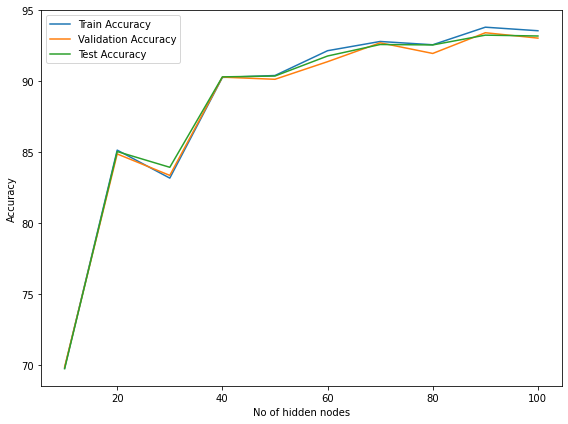

In [51]:
n_hidden = []
train_acc = []
valid_acc = []
test_acc = []

for res in hidden_units_res:
    n_hidden.append(res[0])
    train_acc.append(res[2][0])
    valid_acc.append(res[2][1])
    test_acc.append(res[2][2])

plt.figure(figsize=(8, 6))
plt.plot(n_hidden, train_acc, label='Train Accuracy')
plt.xlabel('No of hidden nodes')
plt.ylabel('Accuracy')

plt.plot(n_hidden, valid_acc, label='Validation Accuracy')
plt.xlabel('No of hidden nodes')
plt.ylabel('Accuracy')

plt.plot(n_hidden, test_acc, label='Test Accuracy')
plt.xlabel('No of hidden nodes')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

### Lambda Val

In [45]:
pool = mp.Pool(8)
lambdaval_res = pool.map(
    infer,
    (
        (90, lambdaval) for lambdaval in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    )
)
pool.close()
pool.join()

<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24b069470c58>:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
<ipython-input-3-24

In [46]:
lambdaval_res

[[90, 0.0, (93.65599999999999, 92.9, 93.16)],
 [90, 0.1, (72.084, 71.91, 72.6)],
 [90, 0.2, (76.25999999999999, 76.1, 77.11)],
 [90, 0.3, (62.6, 62.45, 62.86000000000001)],
 [90, 0.4, (46.93, 47.339999999999996, 47.53)],
 [90, 0.5, (63.902, 63.83, 64.32)],
 [90, 0.6, (63.914, 63.82, 64.31)],
 [90, 0.7, (63.916, 63.82, 64.3)],
 [90, 0.8, (63.55, 63.68000000000001, 63.959999999999994)],
 [90, 0.9, (63.552, 63.68000000000001, 63.959999999999994)],
 [90, 1.0, (63.556000000000004, 63.68000000000001, 63.959999999999994)]]

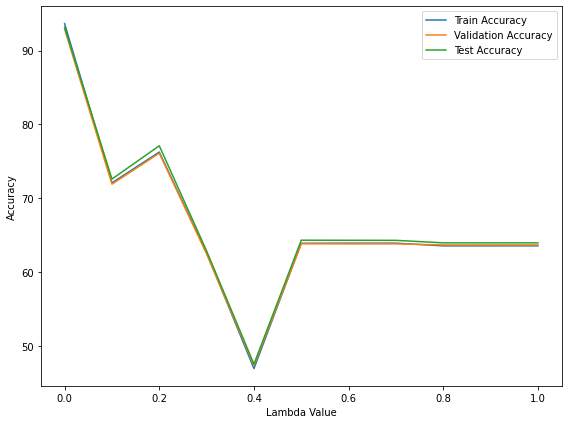

In [52]:
lambdaval = []
train_acc = []
valid_acc = []
test_acc = []

for res in lambdaval_res:
    lambdaval.append(res[1])
    train_acc.append(res[2][0])
    valid_acc.append(res[2][1])
    test_acc.append(res[2][2])

plt.figure(figsize=(8, 6))
plt.plot(lambdaval, train_acc, label='Train Accuracy')
plt.xlabel('Lambda Value')
plt.ylabel('Accuracy')

plt.plot(lambdaval, valid_acc, label='Validation Accuracy')
plt.xlabel('Lambda Value')
plt.ylabel('Accuracy')

plt.plot(lambdaval, test_acc, label='Test Accuracy')
plt.xlabel('Lambda Value')
plt.ylabel('Accuracy')

plt.legend()
plt.show()